In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import pydicom
from skimage.io import imread

from model import *

sys.path.append("../")
from metrics import *
sys.path.append("../../")
from preprocess_helpers import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load Trained Model

In [2]:
# MODEL_NAME = 'unet_lidc_curbest.hdf5'
MODEL_NAME = 'unet_lidc_newbest_9.hdf5'

model = unet_2d_res()
model.load_weights(MODEL_NAME)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Load Data

In [3]:
X_train = np.array([
    imread(f'data/train/image/{im}').reshape(256, 256, 1)/255
    for im in os.listdir('data/train/image/')
])
y_train = np.array([
    imread(f'data/train/label/{im}').reshape(256, 256, 1)
    for im in os.listdir('data/train/label/')
])
print(X_train.shape)
print(y_train.shape)

X_test = np.array([
    imread(f'data/test/image/{im}').reshape(256, 256, 1)/255
    for im in os.listdir('data/test/image/')
])
y_test = np.array([
    imread(f'data/test/label/{im}').reshape(256, 256, 1)
    for im in os.listdir('data/test/label/')
])


print(X_test.shape)
print(y_test.shape)

(5013, 256, 256, 1)
(5013, 256, 256, 1)
(138, 256, 256, 1)
(138, 256, 256, 1)


# Predict

### Train example

1553


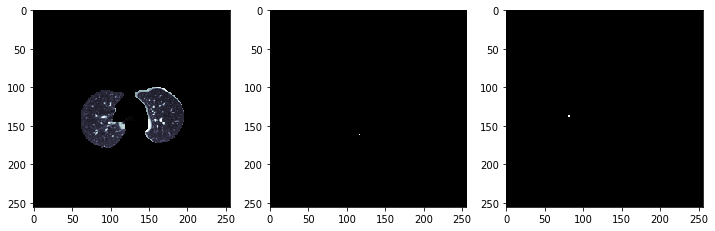

Recall 0.0
Precision 0.0
Dice coefficient 0.14285714285714285
Percent included in ROI 0.0


In [4]:
idx = np.random.randint(len(os.listdir('data/train/image')))
print(idx)

y_hat = model.predict(X_train[[idx]])
thresh = y_hat.max()/2
y_hat[y_hat >= thresh] = 1
y_hat[y_hat < thresh] = 0

fig, axs = plt.subplots(1, 3, figsize=(12, 16))
axs[0].imshow(X_train[idx].reshape(256, 256), cmap='bone')
axs[1].imshow(y_train[idx].reshape(256, 256), cmap='bone')
axs[2].imshow(y_hat.reshape(256, 256), cmap='bone')

plt.show()

print(f"Recall {image_recall(y_train[idx], y_hat[0])}")
print(f"Precision {image_precision(y_train[idx], y_hat[0])}")
print(f"Dice coefficient {dice_coef(y_train[idx], y_hat[0])}")
print(f"Percent included in ROI {percent_included(y_train[idx], y_hat[0])}")

### Test example

78


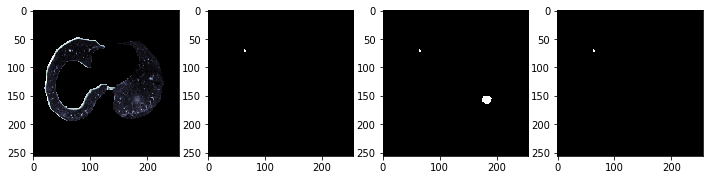

Recall 0.9166666865348816
Precision 0.05288461595773697
Dice Coefficient 0.10407239819004525
Dice Coefficient (Post Processing) 0.9583333333333334
Percent included in ROI 1.0


In [5]:
idx = np.random.randint(len(os.listdir('data/test/image')))
print(idx)
idx=93

y_hat = model.predict(X_test[[idx]])
thresh = y_hat.max()/2
y_hat[y_hat >= thresh] = 1
y_hat[y_hat < thresh] = 0

y_hat_post = get_most_activated_roi_mask(y_hat[0]).reshape(256, 256, 1)

fig, axs = plt.subplots(1, 4, figsize=(12, 20))
axs[0].imshow(X_test[idx].reshape(256, 256), cmap='bone')
axs[1].imshow(y_test[idx].reshape(256, 256), cmap='bone')
axs[2].imshow(y_hat.reshape(256, 256), cmap='bone')
axs[3].imshow(y_hat_post.reshape(256, 256), cmap='bone')
plt.show()

threshold = y_hat[0].max()/2

print(f"Recall {image_recall(y_test[idx], y_hat[0])}")
print(f"Precision {image_precision(y_test[idx], y_hat[0])}")
print(f"Dice Coefficient {dice_coef(y_test[idx], y_hat[0])}")
print(f"Dice Coefficient (Post Processing) {dice_coef(y_test[idx], y_hat_post)}")
print(f"Percent included in ROI {percent_included(y_test[idx], y_hat[0])}")

### Train Overall

In [6]:
train_recall = []
train_precision = []
train_dice = []
train_dice_post = []
train_percent_included = []

for i in range(len(X_train)):
    sys.stdout.write(f'\r{i}')
    y_hat = model.predict(X_train[[i]])
    y_hat_post = get_most_activated_roi_mask(y_hat[0]).reshape(256, 256, 1)
    train_recall.append(image_recall(y_train[i], y_hat[0]))
    train_precision.append(image_precision(y_train[i], y_hat[0]))
    train_dice.append(dice_coef(y_train[i], y_hat[0]))
    train_dice_post.append(dice_coef(y_train[i], y_hat_post))
    train_percent_included.append(percent_included(y_train[i], y_hat[0]))

train_recall = np.array(train_recall)
train_precision = np.array(train_precision)
train_precision = train_precision[np.logical_not(np.isnan(train_precision))]
train_dice = np.array(train_dice)
train_dice_post = np.array(train_dice_post)
train_percent_included = np.array(train_percent_included)

print()
print(np.array(f"Training set average recall: {train_recall.mean()}"))
print(np.array(f"Training set average precision: {train_precision.mean()}"))
print(np.array(f"Training set average dice coefficient: {train_dice.mean()}"))
print(np.array(f"Training set dice coefficient (post): {train_dice_post.mean()}"))
print(np.array(f"Training set average percent included in ROI: {train_percent_included.mean()}"))

5012
Training set average recall: 0.7831119298934937
Training set average precision: 0.608508288860321
Training set average dice coefficient: 0.642328719595514
Training set dice coefficient (post): 0.6621853555830487
Training set average percent included in ROI: 0.8578764352192918


### Test Overall

In [7]:
test_recall = []
test_precision = []
test_dice = []
test_dice_post = []
test_percent_included = []

for i in range(len(X_test)):
    sys.stdout.write(f'\r{i}')
    y_hat = model.predict(X_test[[i]])
    y_hat_post = get_most_activated_roi_mask(y_hat[0]).reshape(256, 256, 1)
    test_recall.append(image_recall(y_test[i], y_hat[0]))
    test_precision.append(image_precision(y_test[i], y_hat[0]))
    test_dice.append(dice_coef(y_test[i], y_hat[0]))
    test_dice_post.append(dice_coef(y_test[i], y_hat_post))
    test_percent_included.append(percent_included(y_test[i], y_hat[0]))

        
test_recall = np.array(test_recall)
test_precision = np.array(test_precision)
test_precision = test_precision[np.logical_not(np.isnan(test_precision))]
test_dice = np.array(test_dice)
test_dice_post = np.array(test_dice_post)
test_percent_included = np.array(test_percent_included)

print()
print(np.array(f"Test set recall: {test_recall.mean()}"))
print(np.array(f"Test set precision: {test_precision.mean()}"))
print(np.array(f"Test set dice coefficient: {test_dice.mean()}"))
print(np.array(f"Test set dice coefficient (post): {test_dice_post.mean()}"))
print(np.array(f"Test set average percent included in ROI: {test_percent_included.mean()}"))

137
Test set recall: 0.8059237003326416
Test set precision: 0.6437575221061707
Test set dice coefficient: 0.6768416462114211
Test set dice coefficient (post): 0.7026239007923275
Test set average percent included in ROI: 0.8985507246376812
